# Bayesian Linear Regression Tutorial

This is a tutorial on implementing Bayesian linear regression. We will use methods described in "Pattern Recognition and Machine Learning" by Christopher Bishop on synthetic regression data. 

The true target variable is denoted as $t$, our model as $y(\textbf{x}, \textbf{w})$, and the prediction error as $\epsilon$ 

$$ t = y(\textbf{x}, \textbf{w}) + \epsilon $$

We will assume that the prediction error is a zero mean Gaussian random variable with precision $\beta$

$$ \epsilon \sim \mathcal{N}(0, \beta^{-1}) $$

Which allows us to define the predicted variable as a Gaussian random variable with precision $\beta$ 

$$ t \sim \mathcal{N}(y(\textbf{x}, \textbf{w}), \beta^{-1}) $$

In this example, we will start by creating a synthetic data set using Scikit-learn's make_regression() with 100 features, 1 target variable, and 150 samples. Additionally, we will apply Gaussian noise to the output variable with a standard deviation of 10, which corresponds to a precision of $\frac{1}{10^{2}}$ = .01.  

In [1]:
import sklearn.datasets
from LR import BLR
from scipy.stats import linregress
import matplotlib.pyplot as plt 
import numpy as np

# number of samples
NS = 150
# number of features
NF = 100 
# define precision as beta
noise = 10        # std deviation 
beta = 1/noise**2 # inverse variance 

X, y = sklearn.datasets.make_regression(n_samples=NS, n_features=NF, n_targets=1, noise=noise)

Let's decompose our data set into training and testing data, setting aside 1/5 of the data for testing. 

In [2]:
N_train = int(.8*NS)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = y[:N_train]
Y_test = y[N_train:]

Fit a Bayesian linear regression model and maximize evidence function

In [3]:
blr = BLR(X_train, Y_train, a=.005, b=beta, max_evidence=True)
print(blr.a)
print(blr.b)

attempting to maximize evidence function
0.003886006751459284
0.010116876658165274


Make Predictions on test data 

In [4]:
Y, E = blr.predict(X_test)

Plot Results! 

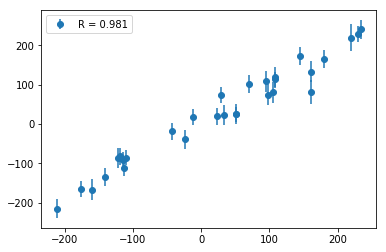

In [5]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y)
plt.errorbar(Y_test, Y, linestyle='none', marker='o', yerr = E.diagonal()**.5, label='R = {:.3f}'.format(r_value))
plt.legend()
plt.show()